In [1]:
import sys,os
import json
import pandas as pd
import regex as re
import shutil

In [2]:
# natural sorting implementation 
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [15]:
DATAPATH='../nero/nero-data/length_roc_data/'

In [16]:
PATHS=DATAPATH+np.array(['./1k/rates','./10k/rates','./50k/rates','./100k/rates','./125k/rates','./150k/rates'])

In [4]:
import glob
import numpy as np

import json
from pathlib import Path
H={}
A={}
AH={}
AH['human']={}
AH['ai']={}
AH['humanstd']={}
AH['aistd']={}
for PATH in PATHS:
    jsonFILES_human=glob.glob(PATH+'/Guten*json')
    jsonFILES_ai=glob.glob(PATH+'/ai*json')
    H[PATH]=[]
    A[PATH]=[]
    
    for path_ in jsonFILES_human:
        # path to the JSON file
        json_path = Path(path_)
        
        with json_path.open("r") as f:
            data = json.load(f)
        
        # extract entropy_rate as a Python list (array-like)
        entropy_rate = data["entropy_rate"]
        H[PATH]=H[PATH]+[pd.DataFrame(entropy_rate).replace(0,None).median().values[0]]
    for path_ in jsonFILES_ai:
        # path to the JSON file
        json_path = Path(path_)
        
        with json_path.open("r") as f:
            data = json.load(f)
        
        # extract entropy_rate as a Python list (array-like)
        entropy_rate = data["entropy_rate"]
        A[PATH]=A[PATH]+[pd.DataFrame(entropy_rate).replace(0,None).median().values[0]]
    AH['human'][PATH]=np.nanmean(H[PATH])
    AH['ai'][PATH]=np.nanmean(A[PATH])
    AH['humanstd'][PATH]=np.nanstd(H[PATH])
    AH['aistd'][PATH]=np.nanstd(A[PATH])
    

In [5]:
df=pd.DataFrame(AH)

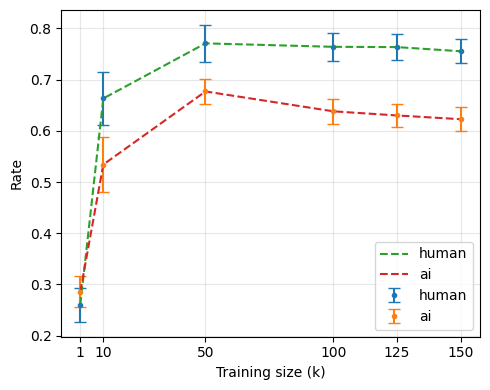

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- data ----
df = pd.DataFrame(AH)
df.index.name = "path"
df = df.reset_index()

df["k"] = df["path"].str.extract(r"(\d+)k", expand=False).astype(int)
df = df.sort_values("k").reset_index(drop=True)

# ---- CI via Student-t (z not hardcoded) ----
n = 100
alpha = 0.01
dfree = n - 1

# t critical value for two-sided (1-alpha) CI
tcrit = float(np.abs(np.quantile(np.random.standard_t(dfree, size=2_000_000), 1 - alpha/2)))

df["human_ci"] = tcrit * (df["humanstd"] / np.sqrt(n))
df["ai_ci"]    = tcrit * (df["aistd"]    / np.sqrt(n))

# ---- plot: scatter w/ error bars, no lines ----
plt.figure(figsize=(5, 4))
ax = plt.gca()

ax.errorbar(df["k"], df["human"], yerr=df["human_ci"],
            fmt=".", linestyle="none", capsize=4, elinewidth=1.5, label="human")
ax.errorbar(df["k"], df["ai"], yerr=df["ai_ci"],
            fmt="o", linestyle="none", capsize=4, elinewidth=1.5, label="ai")

df.set_index('k').human.plot(style='--')
df.set_index('k').ai.plot(style='--')
ax.set_xlabel("Training size (k)")
ax.set_ylabel("Rate")
ax.set_xticks(df["k"].tolist())
ax.legend()
ax.grid(True, alpha=0.3)
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.tight_layout()
#plt.show()
plt.savefig('len.png',dpi=300,bbox_inches='tight')

In [18]:
df.drop('path',axis=1).set_index('k').to_csv('lengthdata.csv')

In [100]:
! pwd

/home/ishanu/Dropbox/ZED/Research/recogai_/nero/nero-data/length_roc_data
